In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57


## Part 1: Data Description

The **players.csv** dataset contains important information about each player of the game, including variables like name, gender, age, etc. Although it is not completely displayed, the dataset contains 196 observations and 7 variables. The variables represent various attributes of a player, including details about their demographic (name, gender, and age), experience level in the game, subscription status, and played hours. The data was collected through a MineCraft server setup by a research group led by Frank Wood, recording actions of players as users played the game. An immediate issue that can be seen in the data is the lack of comparability between quantitative variables. The values will have to be standardized prior to being used in the model.

#### Variable Descriptions

- `experience` - experience level of player
- `subscribe` - subscrption status of player
- `hashedEmail` - player's encrypted email
- `played_hours` - number of hours played by player
- `name` - player name
- `gender` - player gender
- `Age` - player age

Summary of the dataset:

In [7]:
summary(players)

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

## Part 2: Research Question

The broad question that this project will aim to address is "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types". More specifically, we will be focusing on whether or not the `age` and `played_hours` variables can accurately predict `subscribe` status in the players dataset. The data will be important in our research as it allows us to visualize patterns that can be used to determine if our explanatory variables can be used to predict the unknown observation. We plan on scaling the `played_hours` variable to `played_minutes` in order to make it comparable to `Age`, which is needed to apply the KNN classification predictive model. 

## Part 3: Data Analysis and Visualization

In [8]:
## New dataset containing the mean values of all quantitative variables in players.csv
players_mean <- players |>
    summarize( 
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        mean_age = mean(Age, na.rm = TRUE))
players_mean

mean_played_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


#### **Graph 1:**

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


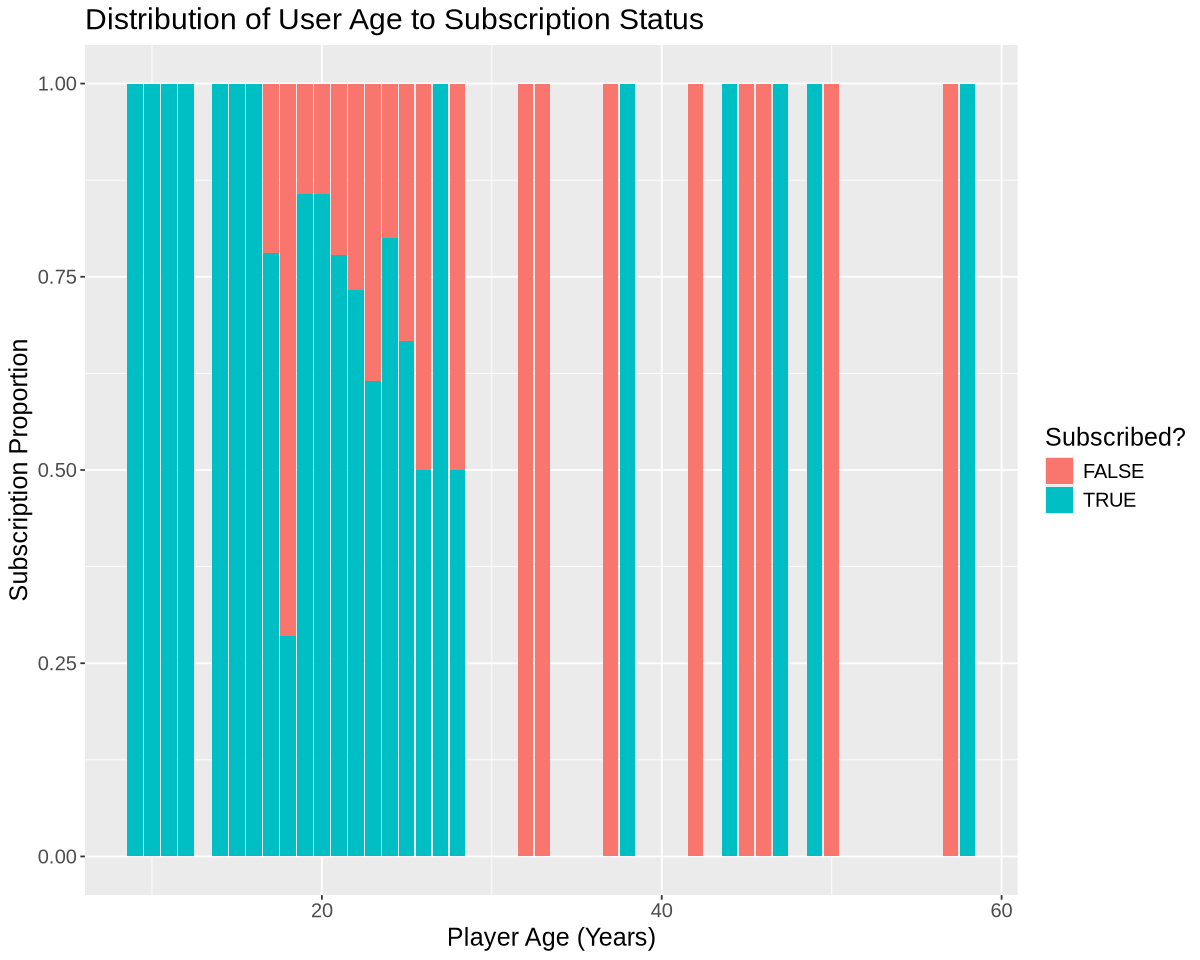

In [9]:
# Subscription status against Age graph
options(repr.plot.width = 10, repr.plot.height = 8)

players_plot1 <- players |>
    ggplot(aes(x = Age, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Player Age (Years)", y = "Subscription Proportion", title = "Distribution of User Age to Subscription Status", fill = "Subscribed?") +
    theme(text = element_text(size = 15))
players_plot1

### Insights:
- Players in age range 15-25 display a higher percentage of subscribed users, suggesting they are more engaged in the game's community
- Certain ages that are 100% true/false indicate that age groups have fewer data points
- Looking at both graphs, age range 15-25 will have most impact on prediction model

#### **Graph 2:**

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


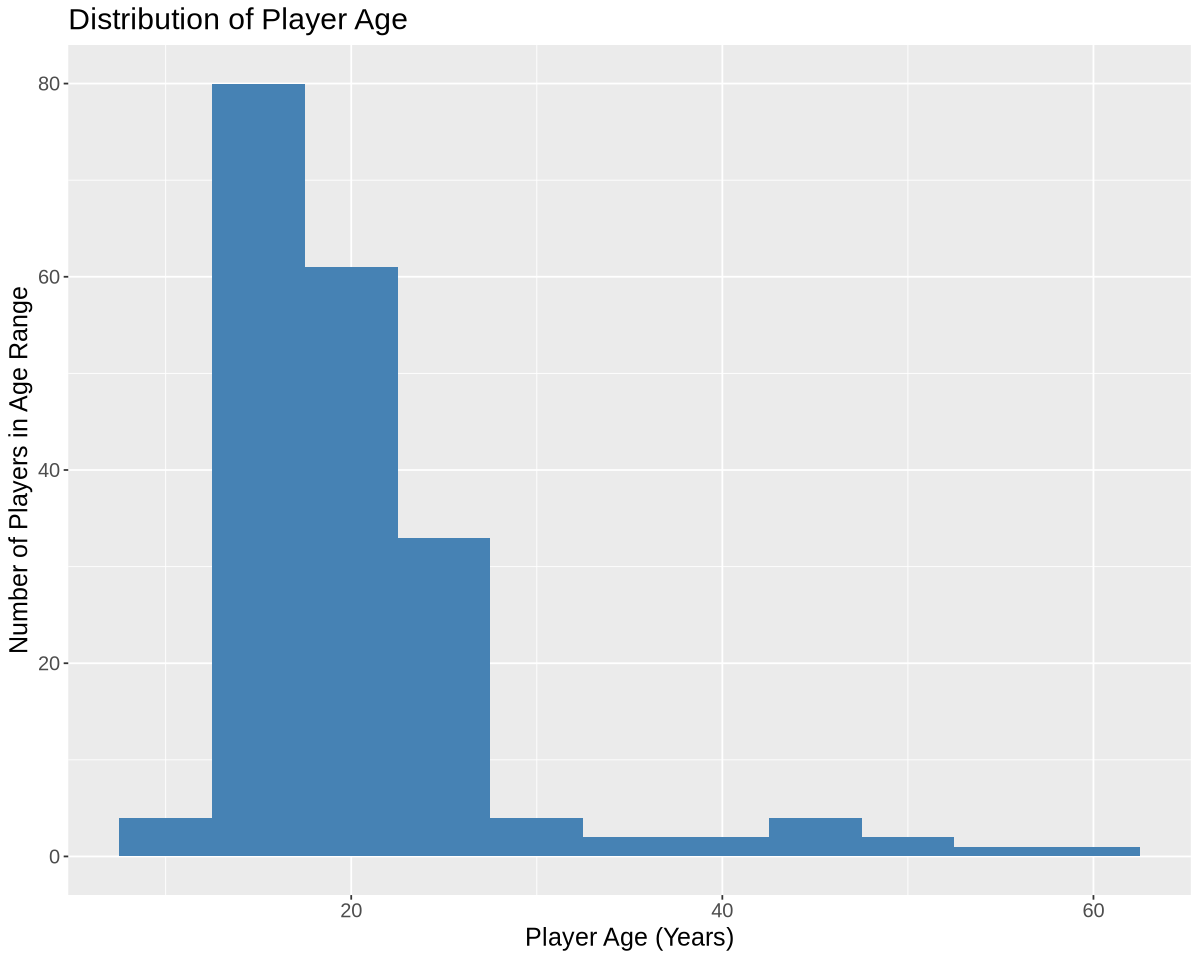

In [10]:
# Player Age Histogram
options(repr.plot.width = 10, repr.plot.height = 8)

players_plot2 <- ggplot(players, aes(x = Age)) +
  geom_histogram(binwidth = 5, fill = "steelblue") +
  labs(title = "Distribution of Player Age", x = "Player Age (Years)", y = "Number of Players in Age Range") +
  theme(text = element_text(size = 15))
players_plot2

### Insights
- Large demographic of users are teenagers, with only a few who are 35 or older
- When using  Age variable in our model, we have to keep in mind that observations of older age ranges will not significantly impact the prediction model